**CPLEX installation guide:** Add following line to your `.bash_profile` (for macOS) after installing IBM ILOG CPLEX Optimization Studio locally using installer from IBM. (note the path will change if you are using different python or OS)

```export PYTHONPATH="/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx"```

In [1]:
import cplex
print(cplex.__path__)  # make sure the path is the one we pick above

['/Applications/CPLEX_Studio1210/cplex/python/3.6/x86-64_osx/cplex']


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util_io import (
    init, finalize, dump_conf, assigned_day_to_family_on_day, assigned_day_to_occupancy
)
from util_cost import (
    cal_total, n_people, family_id_choice_to_pref_cost, cal_total_preference, cal_total_accounting,
    nd_ndp1_to_account_penality, family_id_days_to_pref_cost
)
from util_cost import choices as family_pref
from util_check import deep_check, check_valid_all

## Parameters

In [3]:
# constants #
N_families = 5000
N_days = 100
N_min_people = 125
N_max_people = 300
# constants #

# params #
path_init_conf =     '../output/m24-improved-random.csv'
path_dump_improved = '../output/m23-improved-2.csv' # output solution

num_cpu_cores = 6
#time_limit = -1 # unlimited
time_limit = 1*60*60  # in s

select_days = 20  # N of worst pref cost days selected
occupancy_diff = 0  # +- the occupancy of input solution for each day
occupancy_diff_low = 0  # +- the occupancy of input solution for each day
max_family_rank = 10  # maximum number of rank of the preference days for each family
use_hint = True      # use current input as hint
occupancy_count_as_variables = False  # use occupancy_counts as variable (seem faster)
redundant_occupancy_constraints = True  # use redundant constraints
min_choice_0_families = 3742   # minimum number of families that are at their choice 0
target_pref_cost = 0 # 62868
target_pref_cost_error = 0
target_pref_cost_lower = 0
target_accounting_cost = 0 # 6020.043432
target_accounting_cost_error = 0
target_accounting_cost_lower = 0
max_accounting_cost_per_day = 500

In [4]:
N_families - 62868 / 50

3742.6400000000003

In [5]:
families = range(N_families)
days = range(1, N_days + 1)

In [6]:
#print(list(days))

In [7]:
allowed_occupancy = range(N_min_people, N_max_people + 1)

In [8]:
assigned_day, family_on_day, occupancy = init(path_conf=path_init_conf)
print('Init config:')
try:
    is_valid = deep_check(assigned_day, family_on_day, occupancy)
except:
    is_valid = False
initial_score = cal_total(assigned_day, occupancy)
print('Valid solution: ', is_valid)
print('Total score:    ', initial_score)
print('Preference cost:', cal_total_preference(assigned_day))
print('Accounting cost:', cal_total_accounting(occupancy))

Read initial configs...
Read config completed.
Init config:
deep check: everything looks fine.
Valid solution:  True
Total score:     68939.85040569774
Preference cost: 63175
Accounting cost: 5764.850405697738


In [9]:
print(occupancy, occupancy.shape)

[125 300 288 300 300 284 259 246 249 272 297 300 299 278 266 259 276 297
 290 271 244 218 233 258 286 300 292 273 258 248 246 275 275 251 218 188
 156 125 280 266 242 209 175 154 125 297 277 251 219 188 156 125 280 257
 230 195 162 132 125 264 240 206 166 125 125 125 247 219 183 139 125 125
 125 225 206 173 126 125 125 125 226 212 180 136 126 125 125 255 232 200
 159 125 125 125 227 208 175 128 125 125 125 125] (102,)


In [10]:
init_occupancy_counts = {o: 0 for o in allowed_occupancy}
for o in occupancy[1:-1]:
    init_occupancy_counts[o] += 1
init_occupancy_counts = pd.Series(init_occupancy_counts)

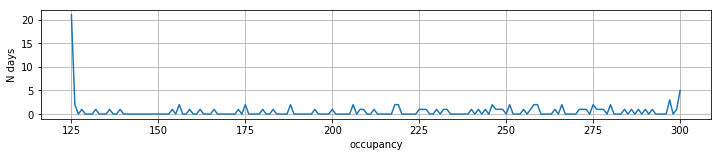

In [11]:
plt.figure(figsize=(12, 2))
plt.plot(init_occupancy_counts); plt.xlabel('occupancy'); plt.ylabel('N days')
plt.ylim(-1, init_occupancy_counts.max()+1); plt.grid(); plt.show()

In [12]:
accounting_cost_per_day = pd.Series({
    day: nd_ndp1_to_account_penality[occupancy[day], occupancy[day+1]].astype('float32')
    for day in days
})

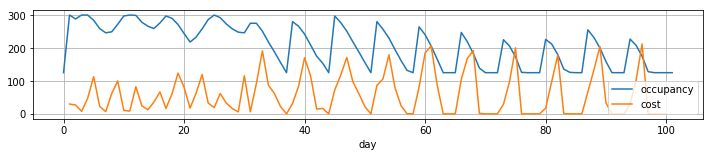

In [13]:
plt.figure(figsize=(12, 2))
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.legend(); plt.grid(); plt.show()

In [14]:
print(max(accounting_cost_per_day), accounting_cost_per_day)

212.26812744140625 1       29.788443
2       26.920185
3        7.577722
4       47.012947
5      112.889999
          ...    
96     212.268127
97       0.113527
98       0.000000
99       0.000000
100      0.000000
Length: 100, dtype: float64


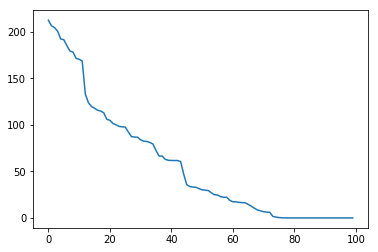

In [48]:
plt.plot(accounting_cost_per_day.sort_values(ascending=False).values)

### Family preferred days

In [15]:
day_rank_count = np.zeros((10, N_days+1), dtype='int32')

In [16]:
for r in range(10):
    family_pref_r = family_pref[:, r]
    for day, size in zip(family_pref_r, n_people):
        day_rank_count[r, day] += size

In [17]:
day_rank_count

array([[   0, 1576,  202, ...,   56,   57,   43],
       [   0, 1478,  131, ...,   53,   64,   41],
       [   0, 1337,  168, ...,   48,   39,   62],
       ...,
       [   0, 1053,  201, ...,   70,   34,   71],
       [   0,  830,  217, ...,   38,   41,   73],
       [   0,  845,  158, ...,   54,   69,   56]], dtype=int32)

In [18]:
day_rank_acc_count = np.zeros((10, N_days+1), dtype='int32')
for rank_acc in range(10):
    day_rank_acc_count[rank_acc] = day_rank_count[rank_acc]
    for r in range(1, rank_acc + 1):
        day_rank_acc_count[rank_acc] += day_rank_count[r]

In [19]:
day_rank_acc_count

array([[    0,  1576,   202, ...,    56,    57,    43],
       [    0,  2956,   262, ...,   106,   128,    82],
       [    0,  4152,   467, ...,   149,   142,   165],
       ...,
       [    0,  9370,  1430, ...,   491,   398,   496],
       [    0,  9977,  1663, ...,   497,   446,   571],
       [    0, 10837,  1762, ...,   567,   543,   610]], dtype=int32)

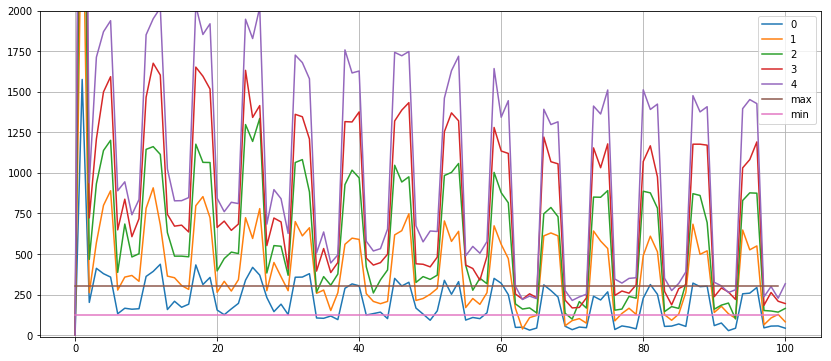

In [20]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.ylim(-10, 2000)
plt.grid(); plt.legend(); plt.show()

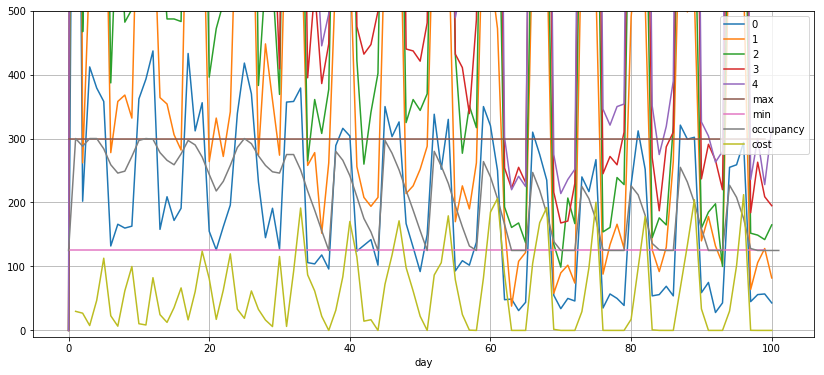

In [21]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

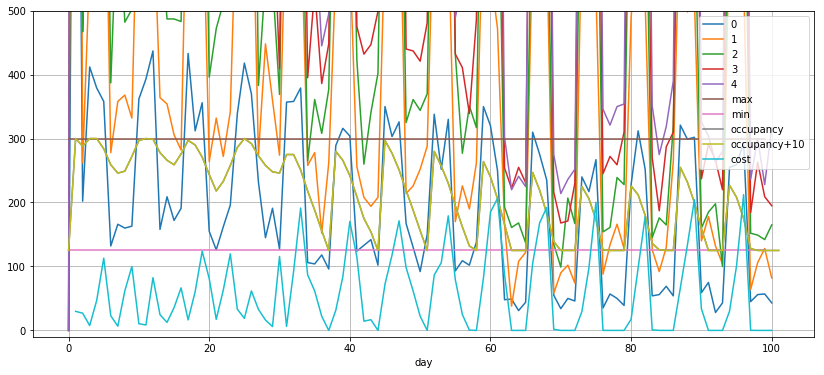

In [22]:
plt.figure(figsize=(14, 6))
for i in range(5):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i))
plt.plot([N_max_people]*N_days, label='max')
plt.plot([N_min_people]*N_days, label='min')
plt.plot(occupancy, label='occupancy')
plt.plot(occupancy+occupancy_diff_low, label='occupancy+10')
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

### Day Family Choice rank

In [23]:
assigned_day

array([ 52,  26, 100, ...,  32,  92,  13], dtype=int32)

In [24]:
assigned_day_pref_rank = (family_pref == assigned_day.reshape(-1, 1)).argmax(axis=1)

In [25]:
assigned_day_pref_rank

array([0, 0, 0, ..., 0, 1, 0])

In [26]:
pd.Series(assigned_day_pref_rank).value_counts()

0    4004
1     755
2     200
3      38
4       3
dtype: int64

In [27]:
df_assigned_day = pd.DataFrame({'day': assigned_day, 'rank': assigned_day_pref_rank, 'n': n_people})

In [28]:
df_day_pref_rank = df_assigned_day.groupby(['day', 'rank'])[['n']].sum().reset_index().pivot(index='day', columns='rank', values='n').fillna(0).astype('int32')

In [29]:
df_day_pref_rank

rank,0,1,2,3,4
day,,,,,
1,300,0,0,0,0
2,202,76,10,0,0
3,287,13,0,0,0
4,283,17,0,0,0
5,279,5,0,0,0
...,...,...,...,...,...
96,175,0,0,0,0
97,45,23,47,13,0
98,56,37,19,13,0


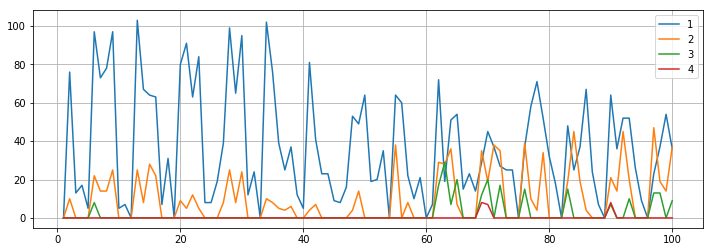

In [30]:
plt.figure(figsize=(12, 4))
for r in range(1, 5):
    plt.plot(df_day_pref_rank[r], label=str(r))
plt.legend(); plt.grid()
plt.show()

In [31]:
families_cost = family_id_days_to_pref_cost[np.arange(N_families), assigned_day]

In [32]:
df_family = pd.DataFrame({'day': assigned_day, 'cost': families_cost})

In [33]:
day_pref_cost = df_family.groupby('day')[['cost']].sum()

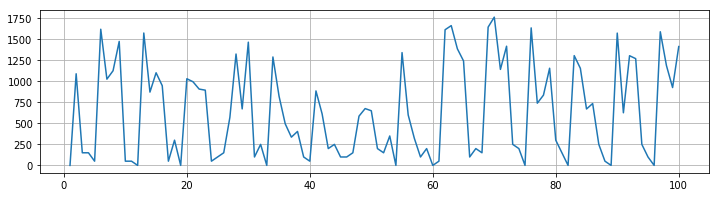

In [34]:
plt.figure(figsize=(12, 3))
plt.plot(day_pref_cost)
plt.grid(); plt.show()

In [35]:
day_pref_cost.sort_values('cost')

,cost
day,
1,0
33,0
75,0
60,0
19,0
...,...
6,1620
76,1636
69,1645


In [36]:
# expensive_days = day_pref_cost.sort_values('cost').iloc[-select_days:].index.values
expensive_days = day_pref_cost.sort_values('cost').iloc[-2*select_days:-select_days].index.values

## Setup

In [37]:
# limit the occupancy choice to +- occupancy_diff of current solution
search_occupancy = {}
for day in days:
#     if day == 1:
#         search_occupancy[day] = [N_max_people]
#     elif day == N_days:
#         search_occupancy[day] = [N_min_people]
    if day in expensive_days:
        search_occupancy[day] = range(N_min_people, N_max_people+1)
    elif occupancy[day] == N_min_people:
        search_occupancy[day] = range(N_min_people, occupancy[day] + occupancy_diff_low + 1)
    else:
        search_occupancy[day] = range(max(occupancy[day] - occupancy_diff, N_min_people),
                                      min(occupancy[day] + occupancy_diff, N_max_people) + 1)

In [38]:
for i, x in search_occupancy.items():
    print(i, x)

1 range(300, 301)
2 range(125, 301)
3 range(300, 301)
4 range(300, 301)
5 range(284, 285)
6 range(259, 260)
7 range(125, 301)
8 range(125, 301)
9 range(272, 273)
10 range(297, 298)
11 range(300, 301)
12 range(299, 300)
13 range(278, 279)
14 range(125, 301)
15 range(125, 301)
16 range(125, 301)
17 range(297, 298)
18 range(290, 291)
19 range(271, 272)
20 range(125, 301)
21 range(125, 301)
22 range(125, 301)
23 range(125, 301)
24 range(286, 287)
25 range(300, 301)
26 range(292, 293)
27 range(273, 274)
28 range(258, 259)
29 range(248, 249)
30 range(246, 247)
31 range(275, 276)
32 range(275, 276)
33 range(251, 252)
34 range(218, 219)
35 range(125, 301)
36 range(156, 157)
37 range(125, 126)
38 range(280, 281)
39 range(266, 267)
40 range(242, 243)
41 range(125, 301)
42 range(175, 176)
43 range(154, 155)
44 range(125, 126)
45 range(297, 298)
46 range(277, 278)
47 range(251, 252)
48 range(219, 220)
49 range(188, 189)
50 range(156, 157)
51 range(125, 126)
52 range(280, 281)
53 range(257, 258)
54

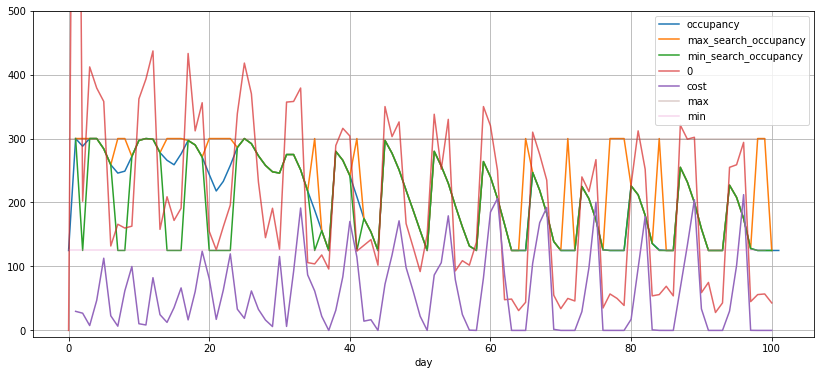

In [39]:
plt.figure(figsize=(14, 6))
plt.plot(occupancy, label='occupancy')
plt.plot(pd.Series({d: max(v) for d, v in search_occupancy.items()}), label='max_search_occupancy')
plt.plot(pd.Series({d: min(v) for d, v in search_occupancy.items()}), label='min_search_occupancy')
for i in range(1):
    row = day_rank_acc_count[i]
    plt.plot(row, label=str(i), alpha=0.7)
plt.plot(accounting_cost_per_day, label='cost'); plt.xlabel('day')
plt.plot([N_max_people]*N_days, label='max', alpha=0.3)
plt.plot([N_min_people]*N_days, label='min', alpha=0.3)
plt.ylim(-10, 500)
plt.grid(); plt.legend(); plt.show()

In [40]:
# occupancy pairs [o, o_next] limited by accounting cost
viable_nd_ndp1 = nd_ndp1_to_account_penality <= max_accounting_cost_per_day

In [41]:
viable_nd_ndp1[N_min_people:N_max_people+1, N_min_people:N_max_people+1].sum()

15130

(125, 300)

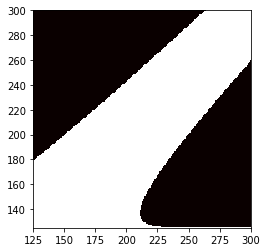

In [42]:
plt.imshow(viable_nd_ndp1, cmap='hot', interpolation='nearest')
plt.xlim(N_min_people, N_max_people)
plt.ylim(N_min_people, N_max_people)

In [43]:
# Possible choice for the family
# last choice is any day that is not on the family's preferred days
N_choices_ori = family_id_choice_to_pref_cost.shape[1]
N_choices = min(N_choices_ori, max_family_rank)
print('Limit family choice rank:', N_choices_ori, '->', N_choices)

Limit family choice rank: 11 -> 10


In [44]:
family_id_choice_to_pref_cost[:, :N_choices]

array([[   0,   50,   86, ...,  444,  544, 1440],
       [   0,   50,   86, ...,  444,  544, 1440],
       [   0,   50,   77, ...,  408,  508, 1205],
       ...,
       [   0,   50,  104, ...,  516,  616, 1910],
       [   0,   50,   95, ...,  480,  580, 1675],
       [   0,   50,   86, ...,  444,  544, 1440]])

## DOCplex model

In [45]:
from docplex.mp.model import Model

In [46]:
solver = Model('')

In [47]:
if num_cpu_cores > 0:
    solver.context.cplex_parameters.threads = num_cpu_cores
    print('Set num threads:', num_cpu_cores)
print('Num treads:', solver.context.cplex_parameters.threads)
if time_limit > 0:
    print('Set time limit:', solver.set_time_limit(time_limit))

Set num threads: 6
Num treads: threads:int(6)
Set time limit: None


In [48]:
solver.parameters.mip.tolerances.mipgap = 0  # set mip gap to 0

## Variables

In [49]:
# Variables
# assignment matrix[family, pref_rank]
assignment_matrix = solver.binary_var_matrix(families, range(N_choices), 'x')

In [50]:
len(assignment_matrix)

25000

In [51]:
possible_family_sizes = np.unique(n_people)

In [52]:
# unpreferred_day_counts[day, size]
if N_choices_ori <= N_choices:
    print('using unpreferred day counts')
    ub = int(N_max_people / possible_family_sizes.min())
    unpreferred_day_counts = solver.integer_var_matrix(days, possible_family_sizes, lb=0, ub=ub, name='d')
    print(len(unpreferred_day_counts))    

In [53]:
# Occupancy matrix [day, N_d, N_d+1]
occupancy_keys_list = []
for day in days:
    if day < N_days:
        for o in search_occupancy[day]:
            for o_next in search_occupancy[day + 1]:
                if viable_nd_ndp1[o, o_next]:
                    occupancy_keys_list.append((day, o, o_next))
    else:
        # last day
        for o in search_occupancy[day]:
            if viable_nd_ndp1[o, o]:
                occupancy_keys_list.append((day, o))
occupancy_matrix = solver.binary_var_dict(occupancy_keys_list, name='o')

In [54]:
search_occupancy[N_days]

range(125, 126)

In [55]:
len(occupancy_matrix)

108362

## Constraints

### constraint 1: each family only take one day (choice)

In [56]:
# Constraints
# constraint 1: each family only take one day (choice)
solver.add_constraints_([
    solver.sum([assignment_matrix[family, c] for c in range(N_choices)]) == 1 
    for family in families
])

### constraint: choices limit

In [57]:
if min_choice_0_families > 0:
    solver.add_constraint_(
        solver.sum([assignment_matrix[family, 0] for family in families]) >= min_choice_0_families
    )

### occupancy counts

In [58]:
# constraint 2: each day can only have 125-300 people

In [59]:
N_family_pref = min(N_choices, N_choices_ori - 1)
N_family_pref

5

In [60]:
# day to dictionary of families who choose this day with value as preference rank
days_family_prefered = [{} for day in range(N_days+1)]  # day = 0 should not be used

In [61]:
for family, pref in enumerate(family_pref):
    for rank, day in enumerate(pref):
        if rank < N_family_pref:
            days_family_prefered[day][family] = rank

In [62]:
# occupancy count [intermediate variables]

if occupancy_count_as_variables:
    lbs = [min(search_occupancy[day]) for day in days]
    ubs = [max(search_occupancy[day]) for day in days]
    occupancy_counts = solver.integer_var_dict(days, lb=lbs, ub=ubs, name='oc')
    
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        solver.add_constraint_(
            occupancy_counts[day] == (
                solver.sum(
                    [assignment_matrix[family, pref_rank] * n_people[family] 
                     for family, pref_rank in family_prefered.items()]
                ) + (
                    solver.sum(
                        [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                    ) if N_choices >= N_choices_ori else 0
                )
            )
        )
else:
    occupancy_counts = {}
    for day in days:
        # find those family who like this day
        family_prefered = days_family_prefered[day]
        occupancy_counts[day] = (
            solver.sum(
                [assignment_matrix[family, pref_rank] * n_people[family] 
                 for family, pref_rank in family_prefered.items()]
            ) + (
                solver.sum(
                    [unpreferred_day_counts[day, size] * size for size in possible_family_sizes]
                ) if N_choices >= N_choices_ori else 0
            )
        )

In [63]:
if not occupancy_count_as_variables:
    for day in days:
        solver.add_range(min(search_occupancy[day]), 
                         occupancy_counts[day], 
                         max(search_occupancy[day]))

### constraint 3: unpreferred day family count conservation for each family size

In [64]:
# constraint 3: unpreferred day family count conservation for each family size

In [65]:
family_size_to_family_ids = {
    size: np.where(n_people == size)[0] for size in possible_family_sizes
}

In [66]:
if N_choices >= N_choices_ori:
    solver.add_constraints_([
        solver.sum([assignment_matrix[family, N_choices - 1]
                    for family in family_size_to_family_ids[size]])
        == solver.sum([unpreferred_day_counts[day, size] for day in days])
        for size in possible_family_sizes
    ])

### Occupancy boolean matrix normalization

In [67]:
# occupancy boolean matrix normalization
# each day only take 1 occupancy value
for day in days:
    if day < N_days:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o, o_next] 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        occupancy_normalization = solver.sum([
            occupancy_matrix[day, o] 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]
        ])
    solver.add_constraint_(occupancy_normalization == 1)

### constrain 4: link occupancy boolean matrix to occupancy count

In [68]:
for day in days:
    if day < N_days:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o, o_next] * o 
            for o in search_occupancy[day]
            for o_next in search_occupancy[day + 1]
            if viable_nd_ndp1[o, o_next]
        ])
    else:
        sum_from_occupancy_matrix = solver.sum([
            occupancy_matrix[day, o] * o 
            for o in search_occupancy[day]
            if viable_nd_ndp1[o, o]            
        ])
    solver.add_constraint_(occupancy_counts[day] == sum_from_occupancy_matrix)

In [69]:
# next day occupancy consistency
solver.add_constraints_([
    occupancy_counts[day + 1] == solver.sum([
        occupancy_matrix[day, o, o_next] * o_next 
        for o in search_occupancy[day]
        for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next]            
    ])
    for day in days if day < N_days
])

# redudant constraints
if redundant_occupancy_constraints:
    for day in days:
        if day + 1 < N_days:
            solver.add_constraints_([
                solver.sum([
                    occupancy_matrix[day, o_other, o] 
                    for o_other in search_occupancy[day] if viable_nd_ndp1[o_other, o]
                ]) == solver.sum([
                    occupancy_matrix[day + 1, o, o_other]
                    for o_other in search_occupancy[day + 2] if viable_nd_ndp1[o, o_other]
                ])
                for o in search_occupancy[day + 1]
            ])
    solver.add_constraints_([
        solver.sum([
            occupancy_matrix[N_days - 1, o_other, o] 
            for o_other in search_occupancy[N_days - 1] if viable_nd_ndp1[o_other, o]
        ]) == occupancy_matrix[N_days, o] if viable_nd_ndp1[o, o] else 0
        for o in search_occupancy[N_days]
    ])

### Preference cost

In [70]:
family_pref_cost = solver.sum([
    assignment_matrix[family, c] * family_id_choice_to_pref_cost[family, c]
    for family in families for c in range(1, N_choices)
])

In [71]:
if target_pref_cost > 0:
    if target_pref_cost_error > 0:
        print('Limit preference cost in range')
        solver.add_range(
            target_pref_cost - target_pref_cost_error,
            family_pref_cost,
            target_pref_cost + target_pref_cost_error
        )
    else:
        print('Limit preference cost exactly')
        solver.add_constraint_(family_pref_cost == target_pref_cost)
elif target_pref_cost_lower > 0:
    print('Lower bound preference cost')
    solver.add_constraint_(family_pref_cost >= target_pref_cost_lower)

### Accounting cost

In [72]:
accounting_cost = (
    solver.sum([
        occupancy_matrix[day, o, o_next] * nd_ndp1_to_account_penality[o, o_next]
        for day in days if day < N_days
        for o in search_occupancy[day] for o_next in search_occupancy[day + 1]
        if viable_nd_ndp1[o, o_next] and o > N_min_people
    ]) +
    solver.sum([
        occupancy_matrix[N_days, o] * nd_ndp1_to_account_penality[o, o]
        for o in search_occupancy[N_days]
        if viable_nd_ndp1[o, o] and o > N_min_people  
    ])
)

In [73]:
if target_accounting_cost > 0:
    if target_accounting_cost_error > 0:
        print('Range limit accounting cost')
        solver.add_range(
            target_accounting_cost - target_accounting_cost_error,
            accounting_cost,
            target_accounting_cost - target_accounting_cost_error
        )
elif target_accounting_cost_lower > 0:
    print('Lower bound accounting cost')
    solver.add_constraint_(accounting_cost >= target_accounting_cost_lower)

In [74]:
#accounting_cost.GetCoeffs()[occupancy_matrix[100, 128]]

## Objective

In [75]:
# Objective - Preference cost only as approximation
solver.minimize(family_pref_cost + accounting_cost)  # family_pref_cost + 

## Hint

In [76]:
if use_hint:
    print('Using hint!')

    from docplex.mp.solution import SolveSolution
    var_value_map = {}
    
    for family in families:
        for c in range(N_choices):
            var_value_map[assignment_matrix[family, c]] = float(
                assigned_day[family] == family_pref[family, c]
            )
    for day in days:
        if day < N_days:
            for o in search_occupancy[day]:
                for o_next in search_occupancy[day + 1]:
                    if viable_nd_ndp1[o, o_next]:
                        var_value_map[occupancy_matrix[day, o, o_next]] = float(
                            (occupancy[day] == o) and (occupancy[day + 1] == o_next)
                        )
                    else:
                        assert not ((occupancy[day] == o) and (occupancy[day + 1] == o_next)), \
                        'Hint not valid at (%i, %i, %i)'%(day, o, o_next)
    for o in search_occupancy[N_days]:
        if viable_nd_ndp1[o, o]:
            var_value_map[occupancy_matrix[N_days, o]] = float(occupancy[N_days] == o)
        else:
            assert not (occupancy[N_days] == o), \
            'Hint not valid at (%i, %i, %i)'%(N_days, o, o)

    if occupancy_count_as_variables:
        for day in days:
            var_value_map[occupancy_counts[day]] = float(occupancy[day])
    
    init_solution = SolveSolution(solver, var_value_map)
    solver.add_mip_start(init_solution)

Using hint!


## Solve

In [77]:
from docplex.mp.progress import TextProgressListener
from docplex.mp.progress import ProgressClock
from docplex.mp.progress import SolutionRecorder

See http://ibmdecisionoptimization.github.io/docplex-doc/mp/docplex.mp.progress.html#docplex.mp.progress.ProgressClock for progress clock parameters meaning

In [78]:
class MyProgressListener(SolutionRecorder):
    def __init__(self, clock=ProgressClock.Gap, absdiff=None, reldiff=None):
        super(MyProgressListener, self).__init__(clock, absdiff, reldiff)
        self.current_objective = initial_score or 999999
        
    def notify_solution(self, sol):
        if self.current_progress_data.current_objective >= self.current_objective:
            return
        print ('Improved solution')
        super(MyProgressListener, self).notify_solution(sol)
        self.current_objective = self.current_progress_data.current_objective
        assigned_day_new_raw = np.ones(N_families, dtype='int32') * -1
        for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
            assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1
        solution = pd.DataFrame(data=families, columns = ['family_id'])
        solution['assigned_day'] = assigned_day_new_raw
        #score = cost_function(preds)
        #print('Score: ' + str(score))        
        solution.to_csv(path_dump_improved, index=False)
        
    def get_solutions(self):
        return self._solutions

In [79]:
# print progress
my_progress_listener = MyProgressListener(clock=ProgressClock.Gap)
solver.add_progress_listener(
#     TextProgressListener(clock=ProgressClock.Gap)
    my_progress_listener
)  
# clock=ProgressClock.Objective, absdiff=10
# ProgressClock.All

In [80]:
print('N of variables (binary, int):', solver.number_of_variables, 
      '(', solver.number_of_binary_variables, ',', solver.number_of_integer_variables, ')')
print('N of constraints:', solver.number_of_constraints)
print('Time limit:', solver.get_time_limit())

N of variables (binary, int): 133362 ( 133362 , 0 )
N of constraints: 8999
Time limit: 3600.0


In [81]:
%%time
# Solve
sol = solver.solve(log_output=True)

if sol is None:
    sol = my_progress_listener.get_solutions()[-1]

print('Solution status:', solver.get_solve_status())
print('Total cost:', sol.objective_value, sol.get_objective_value())
print("Time:", '%.3f' % solver.get_solve_details().time, "s")

Version identifier: 12.10.0.0 | 2019-11-26 | 843d4de
CPXPARAM_Read_DataCheck                          1
CPXPARAM_Threads                                 6
CPXPARAM_RandomSeed                              201903125
CPXPARAM_TimeLimit                               3600
CPXPARAM_MIP_Tolerances_MIPGap                   0
Presolve time = 0.03 sec. (19.25 ticks)
1 of 1 MIP starts provided solutions.
MIP start 'm1' defined initial solution with objective 69604.0789.
Tried aggregator 2 times.
MIP Presolve eliminated 2325 rows and 68164 columns.
MIP Presolve modified 10104 coefficients.
Aggregator did 410 substitutions.
Reduced MIP has 6237 rows, 64888 columns, and 255867 nonzeros.
Reduced MIP has 64873 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.39 sec. (274.36 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 6237 rows, 64888 columns, and 255867 nonzeros.
Reduced MIP has 64873 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.19 sec.

   2952     0    69535.9330   505    69604.0789      Cuts: 16   354213    0.10%
   2952     0    69535.9472   505    69604.0789       Cuts: 6   354236    0.10%
   2952     0    69536.0068   505    69604.0789      Cuts: 10   354282    0.10%
   2952     2    69536.0068   481    69604.0789    69536.4605   354282    0.10%
   2953     3    69547.1423   294    69604.0789    69536.4605   355000    0.10%
   2955     5    69549.0456   302    69604.0789    69536.4605   355322    0.10%
   2963     5    69552.5209   304    69604.0789    69547.2224   355463    0.08%
   2987    28    69556.0949   301    69604.0789    69549.0743   359476    0.08%
   3040    65    69580.0591   190    69604.0789    69549.0743   363741    0.08%
   3179   151    69592.4472   206    69604.0789    69549.1905   369948    0.08%
Elapsed time = 58.34 sec. (56302.00 ticks, tree = 2.26 MB, solutions = 1)
   3317   279    69564.7588   261    69604.0789    69549.1905   381197    0.08%
   3446   331    69569.3369   219    69604.078

  32398 25505    69599.5006   236    69602.0465    69558.6408  2204496    0.06%
  32941 25950    69595.3101   198    69602.0465    69558.6408  2241245    0.06%

Performing restart 2

Repeating presolve.
Tried aggregator 2 times.
MIP Presolve eliminated 44 rows and 1451 columns.
MIP Presolve modified 101 coefficients.
Aggregator did 443 substitutions.
Reduced MIP has 2205 rows, 12261 columns, and 41623 nonzeros.
Reduced MIP has 12249 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.07 sec. (54.84 ticks)
Tried aggregator 1 time.
Reduced MIP has 2205 rows, 12261 columns, and 41623 nonzeros.
Reduced MIP has 12249 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (25.74 ticks)
Represolve time = 0.70 sec. (342.40 ticks)
  33119     0    69536.2022   469    69602.0465       Cuts: 7  2287127    0.06%

GUB cover cuts applied:  1
Cover cuts applied:  182
Flow cuts applied:  41
Mixed integer rounding cuts applied:  207
Zero-half cuts applied:  58
Lift and 

## Solution

In [82]:
assigned_day_new_raw = np.ones(assigned_day.shape, dtype='int32') * -1
for family, choice in sol.get_value_dict(assignment_matrix, keep_zeros=False):
    assigned_day_new_raw[family] = family_pref[family, choice] if choice < N_family_pref else -1

In [83]:
assigned_day_new_raw

array([ 52,  26, 100, ...,  32,  92,  13], dtype=int32)

In [84]:
if N_choices >= N_choices_ori:
    unpreferred_day_counts_sol_dict = sol.get_value_dict(unpreferred_day_counts)
    unpreferred_day_counts_sol = {
        size: [0]+[int(unpreferred_day_counts_sol_dict[day, size]) for day in days]
        for size in possible_family_sizes
    }

    print('Unpreferred families slots:')
    {size: sum(counts) for size, counts in unpreferred_day_counts_sol.items()}

In [85]:
def distribute_unpreferred_day(assigned_day, unpreferred_day_counts_sol, n_people):
    """ Distribute unpreferred day to each family who has -1 day assigned """
    assigned_day = assigned_day.copy()
    unpreferred_days = {size: [] for size in possible_family_sizes}
    for size in possible_family_sizes:
        for day, quota in enumerate(unpreferred_day_counts_sol[size]):
            unpreferred_days[size] = unpreferred_days[size] + [day] * quota
    unpreferred_day_headers = {size: 0 for size in possible_family_sizes}
    for family, (day, size) in enumerate(zip(assigned_day, n_people)):
        if day == -1:
            assigned_day[family] = unpreferred_days[size][unpreferred_day_headers[size]]
            unpreferred_day_headers[size] += 1
    return assigned_day

In [86]:
if N_choices >= N_choices_ori:
    assigned_day_new = distribute_unpreferred_day(assigned_day_new_raw, unpreferred_day_counts_sol, n_people)
else:
    assigned_day_new = assigned_day_new_raw

In [87]:
print('N family unpreferred assigned:', (~(assigned_day_new == assigned_day_new_raw)).sum())

N family unpreferred assigned: 0


In [88]:
family_on_day_new = assigned_day_to_family_on_day(assigned_day_new)
occupancy_new = assigned_day_to_occupancy(assigned_day_new)

In [89]:
try:
    is_valid = deep_check(assigned_day_new, family_on_day_new, occupancy_new)
except:
    is_valid = False
new_score = cal_total(assigned_day_new, occupancy_new)
print('Valid solution: ', is_valid)
print('Total score:    ', new_score, '(', new_score - initial_score, ')')
print('Preference cost:', cal_total_preference(assigned_day_new))
print('Accounting cost:', cal_total_accounting(occupancy_new))

deep check: everything looks fine.
Valid solution:  True
Total score:     69602.04650069324 ( -2.0323831108107697 )
Preference cost: 63974
Accounting cost: 5628.046500693229


## Output

In [90]:
is_improved = new_score < initial_score
if is_valid and (is_improved or (path_dump_improved != path_init_conf)):
    print('output to', path_dump_improved)
    dump_conf(assigned_day_new, path_dump_improved)

output to ../output/m23-improved-1.csv


## Debug

In [91]:
# [
#     [assignment_matrix[family, c].solution_value() for c in range(N_choices)]
#     for family in range(10)
# ]        

In [92]:
# if N_choices >= N_choices_ori:
#     print([
#         [unpreferred_day_counts[day, size].solution_value() for size in possible_family_sizes]
#         for day in range(1, 10)
#     ])